In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import log, exp, prod
from scipy.interpolate import RegularGridInterpolator
import scipy.optimize as opt

In [2]:
T0 = 298 # Kelvin
R = 8.314e3 # J/ mol*K

In [3]:
standard_state_df = pd.read_excel("standard_state_params.xlsx").set_index("Unnamed: 0")
# arr of standard state parameter s per species
standard_state_df.T

Unnamed: 0,CO,CO2,CH3OH,H2O,H2
A,3.376000,5.457000,2.211000,3.47000,3.249000
B,0.000557,0.001045,0.012216,0.00145,0.000422
C,0.000000,0.000000,-0.000003,0.00000,0.000000
D,-3100.000000,-115700.000000,0.000000,12100.00000,8300.000000
H,-110525.000000,-393509.000000,-200660.000000,-241818.00000,0.000000
G,-137169.000000,-394359.000000,-161960.000000,-228572.00000,0.000000


In [4]:
nu_arr = np.array([[0, -1, 1, 1, -3], [1, -1, 0, 1, -1],[-1, 0, 1, 0, -2]]).T 
# array of rxn coeffs
nu_arr

array([[ 0,  1, -1],
       [-1, -1,  0],
       [ 1,  0,  1],
       [ 1,  1,  0],
       [-3, -1, -2]])

In [5]:
state_vars_df = pd.DataFrame(np.dot(standard_state_df.T.values, nu_arr))
state_vars_df.index = ["Δ"+v for v in standard_state_df.columns]
state_vars_df

,0,1,2
ΔA,-9.523000,-1.86000,-7.663000
ΔB,0.011355,0.00054,0.010815
ΔC,-0.000003,0.00000,-0.000003
ΔD,102900.000000,116400.00000,-13500.000000
ΔH,-48969.000000,41166.00000,-90135.000000
ΔG,3827.000000,28618.00000,-24791.000000


In [40]:
deltah_rt = lambda T_inv: np.multiply(T_inv/R,state_vars_df.loc[["ΔH"],:].T.values)
enthalpy_correction = lambda T_inv: np.multiply(T_inv,np.dot(state_vars_df.loc[["ΔA", "ΔB", "ΔC", "ΔD"],:].T.values, np.array([T_inv**-1 - T0, (T_inv**-2 - T0**2)/2, (T_inv**-3 - T0**3)/3, (T_inv**-1 - T0)/(T0*T_inv**-1)])))
entropy_correction = lambda T_inv: np.multiply(T_inv,np.dot(state_vars_df.loc[["ΔA", "ΔB", "ΔC", "ΔD"],:].T.values, np.array([-log(T_inv*T0), T_inv**-1 - T0, (T_inv**-2 - T0**2)/2, (T_inv**-2 - T0**2)/(2*(T_inv**-2)*(T0**2))])))
corrections = lambda T_inv: enthalpy_correction(T_inv)-entropy_correction(T_inv)
lnk0 = np.multiply(state_vars_df.loc[["ΔG"],:].T.values-state_vars_df.loc[["ΔH"],:].T.values,1/(R*T0))
lnk = lambda T_inv: (np.array([(-lnk0-deltah_rt(T_inv))[i]-corrections(T_inv)[i] for i in range(3)]))

Text(0.5, 1.0, 'ln K vs. 1/T')

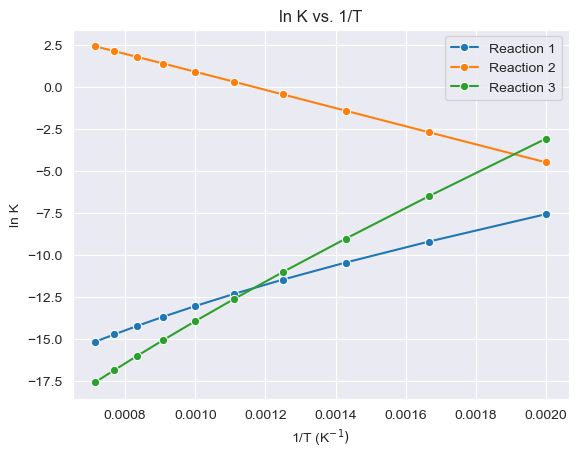

In [41]:
sns.lineplot(x=[x**-1 for x in range(500, 1500, 100)], y=[lnk(x**-1).item(0) for x in range(500, 1500, 100)], label="Reaction 1",marker="o")
sns.lineplot(x=[x**-1 for x in range(500, 1500, 100)], y=[lnk(x**-1).item(1) for x in range(500, 1500, 100)], label="Reaction 2", marker="o")
sns.lineplot(x=[x**-1 for x in range(500, 1500, 100)], y=[lnk(x**-1).item(2) for x in range(500, 1500, 100)], label="Reaction 3", marker="o")
plt.xlabel(r"1/T (K$^{-1})$")
plt.ylabel(r"ln K")
plt.title("ln K vs. 1/T")

# Problem 2

In [42]:
R = 8.314 # Convert from J to kJ
Tc = np.array([132.9, 304.2, 512.6, 647.1, 33.19]) # K
Pc = np.array([34.99, 73.83, 80.97, 220.55, 13.13]) # bar
omega = np.array([0.048, 0.224, 0.564, 0.345, -0.216])
feed = np.array([0,1,0,0,3])


In [43]:
phi_0_df = pd.read_excel("Lee_Kesler_Correlation.xlsx","phi_0")
phi_1_df = pd.read_excel("Lee_Kesler_Correlation.xlsx","phi_1")

In [44]:
Pr = phi_0_df.axes[1][1:].values
Tr = phi_0_df.T_r.values
phi_0 = phi_0_df.loc[:,Pr].values
interpolator0 = RegularGridInterpolator((Tr, Pr), phi_0)
Pr1 = phi_1_df.axes[1][1:].values
Tr1 = phi_1_df.T_r.values
phi_1 = phi_1_df.loc[:,Pr].values
interpolator1 = RegularGridInterpolator((Tr1, Pr1), phi_1)
fugacity = lambda T_r, P_r, pitz: interpolator0((T_r, P_r)).item(0)*interpolator0((T_r, P_r)).item(0)**pitz

In [45]:
vapor_compositions = lambda coord_vec: (np.dot(nu_arr, coord_vec)+feed)/(4+np.dot(np.sum(nu_arr, axis=0),coord_vec))
phi = lambda T,P: np.array([fugacity(T/crit_temp, P/crit_press, pitz) if T/crit_temp<=4 else 1 for crit_temp, crit_press, pitz in zip(Tc, Pc, omega)])

In [51]:
def equilibrium_rxn_eqs(rxn_coord_vec, temp):
    errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [50**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,50), nu_arr[:,j])]) for j in range(3)]))
    return (errors @ errors.T)*1e6**np.sum(vapor_compositions(rxn_coord_vec)< 0)

In [54]:
bounds = [(0, 1)]
composition_df = pd.DataFrame()
for temp in range(500,1501,100):
    coord_solns = opt.differential_evolution(equilibrium_rxn_eqs, [bounds[0], bounds[0], bounds[0]], args=([temp]))
    composition_df[temp] = vapor_compositions(coord_solns.x)
composition_df = composition_df.T

/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/2148514319.py:2: RuntimeWarning: divide by zero encountered in scalar power
  errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [50**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,50), nu_arr[:,j])]) for j in range(3)]))
/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/2148514319.py:2: RuntimeWarning: divide by zero encountered in scalar power
  errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [50**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,50), nu_arr[:,j])]) for j in range(3)]))
/Users/nosmo/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [55]:
composition_df.columns = standard_state_df.T.columns
composition_df

Unnamed: 0,CO,CO2,CH3OH,H2O,H2
500,0.005373,0.148699,0.191857,0.197230,0.456842
600,0.051740,0.158148,0.080224,0.131964,0.577923
700,0.126841,0.115448,0.015423,0.142264,0.600025
800,0.171424,0.077311,0.002530,0.173954,0.574781
900,0.198565,0.051170,0.000529,0.199094,0.550641
1000,0.215528,0.034401,0.000141,0.215669,0.534261
1100,0.226117,0.023860,0.000046,0.226163,0.523814
1200,0.232805,0.017186,0.000017,0.232823,0.517169
1300,0.237002,0.012994,0.000008,0.237009,0.512987
1400,0.239913,0.010086,0.000004,0.239916,0.510082


Text(0.5, 1.0, 'Molar Composition of Species at 50 bar, 500 - 1500 K')

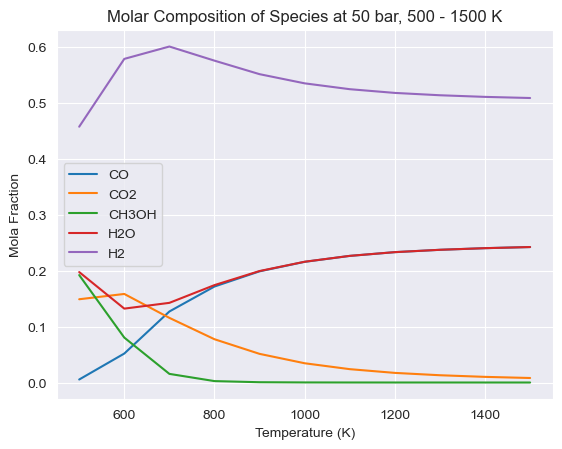

In [56]:
for i in range(5):
    sns.lineplot(x=composition_df.index, y=composition_df.loc[:,standard_state_df.T.columns[i]], label=standard_state_df.T.columns[i])
plt.xlabel("Temperature (K)")
plt.ylabel("Mola Fraction")
plt.title("Molar Composition of Species at 50 bar, 500 - 1500 K")

In [77]:
composition_df["yield"]= composition_df.loc[:,"CH3OH"]/0.75
composition_df

Unnamed: 0,CO,CO2,CH3OH,H2O,H2,yield
500,0.005373,0.148699,0.191857,0.197230,0.456842,0.255809
600,0.051740,0.158148,0.080224,0.131964,0.577923,0.106966
700,0.126841,0.115448,0.015423,0.142264,0.600025,0.020564
800,0.171424,0.077311,0.002530,0.173954,0.574781,0.003373
900,0.198565,0.051170,0.000529,0.199094,0.550641,0.000705
1000,0.215528,0.034401,0.000141,0.215669,0.534261,0.000188
1100,0.226117,0.023860,0.000046,0.226163,0.523814,0.000061
1200,0.232805,0.017186,0.000017,0.232823,0.517169,0.000023
1300,0.237002,0.012994,0.000008,0.237009,0.512987,0.000010
1400,0.239913,0.010086,0.000004,0.239916,0.510082,0.000005


In [78]:
composition_df.describe()

Unnamed: 0,CO,CO2,CH3OH,H2O,H2,yield
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.177022,0.059761,0.026435,0.203456,0.533326,0.035246
std,0.081819,0.056696,0.059836,0.039047,0.040312,0.079781
min,0.005373,0.008068,0.000002,0.131964,0.456842,0.000003
25%,0.149133,0.015090,0.000013,0.185592,0.511534,0.000017
50%,0.215528,0.034401,0.000141,0.215669,0.523814,0.000188
75%,0.234904,0.096379,0.008976,0.234916,0.562711,0.011968
max,0.241931,0.158148,0.191857,0.241933,0.600025,0.255809


# Sensitivity Analysis
## Feed Ratio


In [103]:
composition_df = pd.DataFrame()
for ratio in range(3,11):
    feed = np.array([0,1,0,0,ratio])
    composition_df[ratio] = [vapor_compositions(opt.differential_evolution(equilibrium_rxn_eqs, [bounds[0], bounds[0], bounds[0]], args=([temp])).x)[2]/(ratio/(ratio+1)) for temp in range(500,1501,100)]
composition_df = composition_df.T
composition_df.columns = [temp for temp in range(500,1501,100)]


/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/2148514319.py:2: RuntimeWarning: divide by zero encountered in scalar power
  errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [50**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,50), nu_arr[:,j])]) for j in range(3)]))
/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/2148514319.py:2: RuntimeWarning: divide by zero encountered in scalar power
  errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [50**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,50), nu_arr[:,j])]) for j in range(3)]))
/Users/nosmo/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/21

In [104]:
composition_df

,500,600,700,800,900,1000,1100,1200,1300,1400,1500
3,0.255809,0.106966,0.020564,0.003373,0.000705,0.000188,0.000061,0.000023,0.000010,0.000005,0.000003
4,0.371418,0.173702,0.039269,0.006742,0.001434,0.000386,0.000126,0.000048,0.000021,0.000010,0.000005
5,0.473571,0.251000,0.064492,0.011382,0.002432,0.000656,0.000215,0.000083,0.000036,0.000017,0.000009
6,0.527393,0.330891,0.096485,0.017341,0.003703,0.000998,0.000327,0.000125,0.000055,0.000026,0.000014
7,0.544983,0.400017,0.135132,0.024670,0.005250,0.001413,0.000463,0.000177,0.000077,0.000037,0.000020
8,0.548428,0.449229,0.179408,0.033427,0.007076,0.001899,0.000621,0.000238,0.000103,0.000050,0.000026
9,0.547266,0.479788,0.226865,0.043678,0.009183,0.002457,0.000803,0.000307,0.000134,0.000065,0.000034
10,0.544721,0.497655,0.273832,0.055483,0.011578,0.003089,0.001008,0.000385,0.000168,0.000081,0.000043


Text(0.5, 1.0, 'Methanol Yield under Different $CO_2:H_2$ Feed Ratios at 50 bar, 500 - 1500 K')

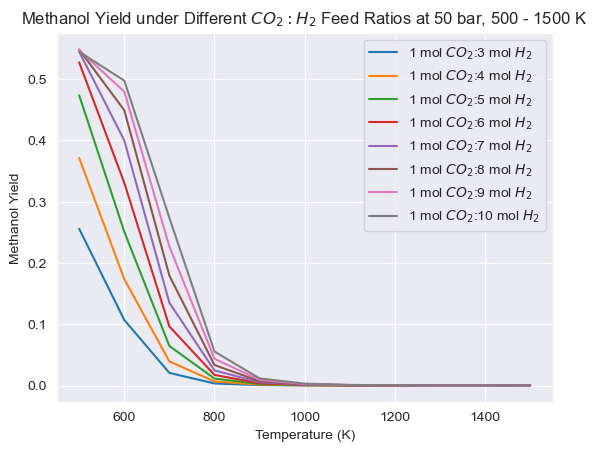

In [107]:
for i in range(3,11):
    sns.lineplot(x=composition_df.columns, y=composition_df.loc[i,:], label=r"1 mol $CO_2$:"+f"{i}"+r" mol $H_2$")
plt.xlabel("Temperature (K)")
plt.ylabel("Methanol Yield")
plt.title("Methanol Yield under Different $CO_2:H_2$ Feed Ratios at 50 bar, 500 - 1500 K")

## Pressure

In [109]:
feed = np.array([0,1,0,0,3])
def equilibrium_rxn_eqs_p(rxn_coord_vec, temp, pressure):
    errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [pressure**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,pressure), nu_arr[:,j])]) for j in range(3)]))
    return (errors @ errors.T)*1e6**np.sum(vapor_compositions(rxn_coord_vec)< 0)


In [110]:
composition_df = pd.DataFrame()
pressures = [10, 25, 50, 75, 100, 125, 150]
for pressure in pressures:
    composition_df[pressure] = [vapor_compositions(opt.differential_evolution(equilibrium_rxn_eqs_p, [bounds[0], bounds[0], bounds[0]], args=(temp, pressure)).x)[2]/0.75 for temp in range(500,1501,100)]
composition_df = composition_df.T
composition_df.columns = [temp for temp in range(500,1501,100)]

/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/1917453450.py:3: RuntimeWarning: divide by zero encountered in scalar power
  errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [pressure**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,pressure), nu_arr[:,j])]) for j in range(3)]))
/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/1917453450.py:3: RuntimeWarning: divide by zero encountered in scalar power
  errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [pressure**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,pressure), nu_arr[:,j])]) for j in range(3)]))
/Users/nosmo/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/gt/jry5dk4n7kb1m516h15zrp5h000

In [111]:
composition_df

,500,600,700,800,900,1000,1100,1200,1300,1400,1500
10,0.063274,0.007549,0.000823,0.000128,0.000027,0.000007,0.000002,9.243899e-07,4.024125e-07,1.947462e-07,1.030164e-07
25,0.152696,0.040072,0.005232,0.000819,0.000172,0.000046,0.000015,5.795531e-06,2.517276e-06,1.217166e-06,6.430581e-07
50,0.255809,0.106966,0.020564,0.003373,0.000705,0.000188,0.000061,2.329559e-05,1.010627e-05,4.873623e-06,2.568749e-06
75,0.340715,0.165205,0.043526,0.007725,0.001616,0.000429,0.000139,5.265408e-05,2.276219e-05,1.094187e-05,5.760726e-06
100,0.408906,0.213736,0.070678,0.013861,0.002927,0.000772,0.000249,9.402191e-05,4.051024e-05,1.944624e-05,1.021641e-05
125,0.454030,0.255110,0.099127,0.021670,0.004639,0.001220,0.000391,1.470892e-04,6.329766e-05,3.031400e-05,1.593591e-05
150,0.485125,0.292992,0.127260,0.030900,0.006753,0.001773,0.000566,2.124986e-04,9.120048e-05,4.358638e-05,2.286329e-05


Text(0.5, 1.0, 'Methanol Yield under Different Pressures at 500 - 1500 K')

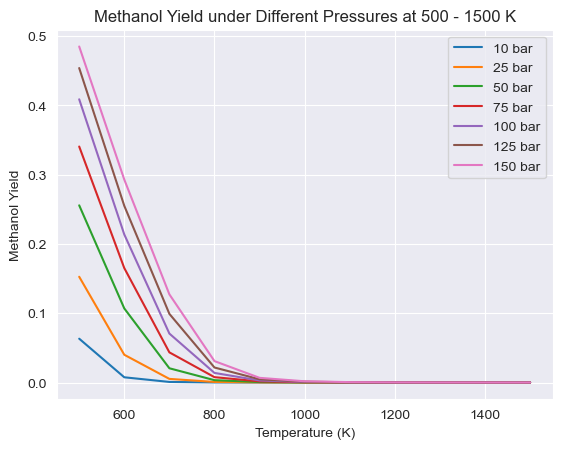

In [114]:
for i in range(len(pressures)):
    sns.lineplot(x=composition_df.columns, y=composition_df.loc[pressures[i],:], label=f"{pressures[i]} bar")
plt.xlabel("Temperature (K)")
plt.ylabel("Methanol Yield")
plt.title("Methanol Yield under Different Pressures at 500 - 1500 K")

# Problem 4a (Optimal Operation Conditions)
**operation_params:**
* 0: Temperature (500 - 1500 K)
* 1: Pressure (10 - 150 bar)
* 2: Molar Composition of H<sub>2</sub> in Feed Stream (0.75 - 0.99)

In [116]:
reactor = lambda operation_params: vapor_compositions(opt.differential_evolution(equilibrium_rxn_eqs_p, [bounds[0], bounds[0], bounds[0]], args=(operation_params[0], operation_params[1])).x)[2]/(operation_params[2])

In [ ]:
opt.differential_evolution(reactor, [(500, 1500), (10, 150), (0.75, 0.99)])

/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/1917453450.py:3: RuntimeWarning: divide by zero encountered in scalar power
  errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [pressure**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,pressure), nu_arr[:,j])]) for j in range(3)]))
/var/folders/gt/jry5dk4n7kb1m516h15zrp5h0000gn/T/ipykernel_49268/1917453450.py:3: RuntimeWarning: divide by zero encountered in scalar power
  errors = (np.multiply([exp(lk) for lk in lnk(1/temp)], [pressure**vi for vi in -np.sum(nu_arr, axis=0)]) - np.array([prod([ (yi*phi_i)**nu_i for yi,phi_i, nu_i in zip(vapor_compositions(rxn_coord_vec),phi(temp,pressure), nu_arr[:,j])]) for j in range(3)]))
/Users/nosmo/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/gt/jry5dk4n7kb1m516h15zrp5h000